# Data import and Set-up

First, we will import our libraries.

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

from collections import Counter
import sklearn

# Scikit-learn libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Scikit-learn libraries for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import *

# Ignoring all warnings throughout the notebook
import warnings
warnings.filterwarnings('ignore')

sklearn.__version__

'0.23.2'

Now, we will fetch the latest dataset available in Austin Texas Dataset, and we will adapt the format of the dataset, to fit with future work.

In [2]:
import requests
import os.path

if os.path.isfile('./data/train.csv') and os.path.isfile('./data/test.csv'):
    print ("Datasets already fetched, delete them if you want the latest datasets!")
else:
    print ("Downloading and preparing datasets...")

    outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

    params = {'$limit': 10000000} # If not specified it only returns 1000 records
    request = requests.get(outcomes_endpoint, params)
    out_df = pd.DataFrame(request.json())

    # Drop two unnecessary columns. 
    out_df.drop(['monthyear', 'date_of_birth'], axis=1, inplace=True)

    # Re-order Columns
    out_df = out_df[['animal_id','name','datetime','outcome_type','outcome_subtype', 
                     'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color']]

    # Re-name Columns
    out_df.columns = ['AnimalID','Name','DateTime','OutcomeType','OutcomeSubtype', 'AnimalType', 
                      'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
    
    # Clean unnecessary rows, we will focus on the 4 main outcomes.
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Rto-Adopt'].index)
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Disposal'].index)
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Missing'].index)
    out_df = out_df.drop(out_df[out_df['OutcomeType'] == 'Relocate'].index)
    
    # Clean Bird/Livestock rows, there is no enough data.
    #out_df = out_df.drop(out_df[out_df['AnimalType'] == 'Bird'].index)
    out_df = out_df.drop(out_df[out_df['AnimalType'] == 'Livestock'].index)

    # Re-name Columns in test_df
    out_df.columns = ['ID','Name','DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalType', 
                      'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
    # Reset the IDs in test_df
    #test_df['ID'] = np.arange(len(test_df.index))

    # Save both dataframes
    if not os.path.exists('./data'):
        os.makedirs('./data')
        
    out_df.to_csv('./data/shelter_dataset.csv', index=False)
    
    print("Done.")

Done.


Next, we load our data, which had already been separated into training and test data.

In [3]:
# Training and test dataframes, and its structure.
df = pd.read_csv('./data/shelter_dataset.csv')


# Exporatory Data Analysis (EDA)
First, we look if we have outliers of missing data for each feature.

In [4]:
# Describe the dataset.
df.describe()

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,121494,83452,121494,121395,56318,121494,121491,121403,121494,121494
unique,108792,19468,100290,5,22,4,5,51,2597,591
top,A721033,Max,2016-04-18T00:00:00.000,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,31,542,39,54356,30446,68955,42689,21420,31079,12767


In [5]:
# Show percent of total data in the training dataframe

In [6]:
df_counts = pd.DataFrame({'Column Count' : df.count(), 
   ....:                      '% Percent of Total Data' : df.count().div(max(df.count())) * 100})

df_counts.round(1)

,Column Count,% Percent of Total Data
ID,121494,100.0
Name,83452,68.7
DateTime,121494,100.0
OutcomeType,121395,99.9
OutcomeSubtype,56318,46.4
AnimalType,121494,100.0
SexuponOutcome,121491,100.0
AgeuponOutcome,121403,99.9
Breed,121494,100.0
Color,121494,100.0


Our initial look at the data reveals 97,216 rows. `Name` is not included for 30,503 cases, but is included for 68.6% of the data. A large quantity of `OutcomeSubtype` data is missing, which we worked to quantify below. Aside from these two columns, we had at least 99.9% of the data in every other column.

We are choosing not to use the `Name` variable, as we have blanks for 31.4% of the data, and animals have high variety of names, so the variable had few commonalities among animals. We feel that this level of sparsity within `Name` will not help us to predict the animals outcomes. This makes logical sense as well, as `Name` seems unlikely to be the deciding factor in whether an animal is adopted.

# Class Variable Review

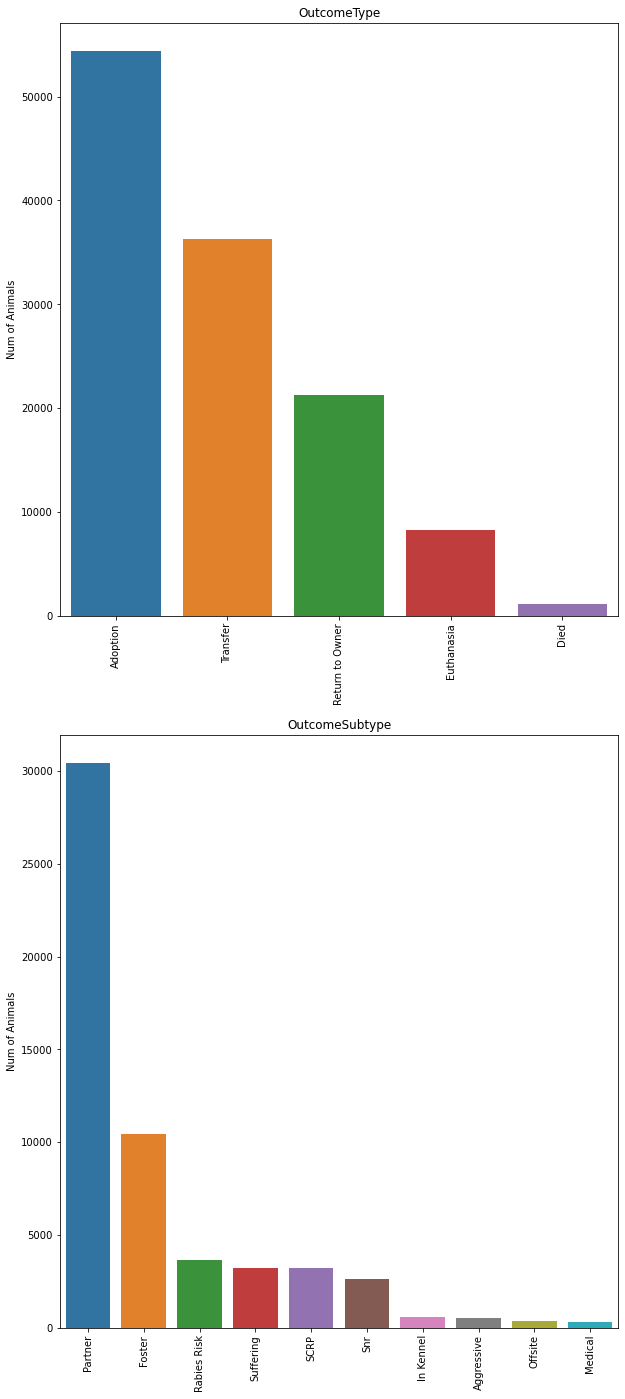

In [7]:
# Obtain headers.
headers = df.dtypes.index

# Categorical headers of classes.
cat_headers = ['OutcomeType', 'OutcomeSubtype']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot = df[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Num of Animals")
fig.show()

Overall, we see a large imbalance between the outcome classes, which we will discuss further below in our modeling section. The outomes lean heavily toward Adoption, Transfer, and Return to Owner. There is a smaller portion of Euthanasia outcomes, and a very small number of Died outomes.

While the `Outcome Subtype` variable is also missing for many animals, we do not predict based on this variable.

In [8]:
df_sub = df[df['OutcomeSubtype'].isnull()]
df_sub.head()

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A821019,Spot,2020-12-08T12:37:00.000,Adoption,NaN,Dog,Neutered Male,3 years,Pit Bull,White/Black
1,A824438,*Rose,2020-12-08T12:27:00.000,Adoption,NaN,Dog,Spayed Female,9 years,German Shepherd,Tan/Black
5,A826884,NaN,2020-12-08T11:49:00.000,Return to Owner,NaN,Cat,Intact Female,5 months,Domestic Shorthair,Brown Tabby
16,A826860,Chi Chi,2020-12-08T11:20:00.000,Return to Owner,NaN,Dog,Intact Female,5 years,German Shepherd Mix,Tan/White
20,A825923,Harvey,2020-12-08T00:00:00.000,NaN,NaN,Cat,Intact Male,NaN,Domestic Shorthair,Unknown


From the data in the table above, we surmise that it is possible the majority of the subtype null data is from the `Return to Owner` or `Adoption` outcome type data. We will examine this further below.

In [9]:
df_sub_2 = df_sub['OutcomeType'].value_counts().reset_index(name='Count of Null')
df_sub_2.rename(index=str, columns={"index": "Outcome Types"})

,Outcome Types,Count of Null
0,Adoption,43512
1,Return to Owner,21233
2,Euthanasia,223
3,Died,109


34,777 of the Adoption outcome entries have the outcome subtype as `null`. As we already have outcome subtypes for barn, foster, and offsite within adoption, we feel confident in assuming that these missing subtypes are simply the animals that were adopted. We will assume this is true and fill these null values with `adopted`.

As the return-to-owner outcome type also has no subtype, we will make the outcome subtype `return to owner`. It seems that, within the dataset, when the outcome subtype would have been redundant with the outcome type, the outcome subtype was not always listed. Logically, once an animal is adopted or returned to their owner, a shelter feels it does not need further classification or follow up on specific outcomes.

For the remaining 23 null outcome subtypes, we will label their subtype as `other`.

In [10]:
def subtype(x):
    if x['OutcomeType'] == 'Adoption' and pd.isnull(x['OutcomeSubtype']) : return 'Adopted'
    elif x['OutcomeType'] == 'Return_to_owner' and pd.isnull(x['OutcomeSubtype']): return 'Return to Owner'
    elif pd.isnull(x['OutcomeSubtype']) : return 'Other'
    else: return x['OutcomeSubtype']

df['OutcomeSubtype'] = df.apply(subtype, axis=1)

In [11]:
df.groupby(['OutcomeType', 'OutcomeSubtype']).size().reset_index(name='Count')

,OutcomeType,OutcomeSubtype,Count
0,Adoption,Adopted,43512
1,Adoption,Barn,3
2,Adoption,Foster,10458
3,Adoption,Offsite,383
4,Died,At Vet,87
5,Died,Enroute,83
6,Died,In Foster,270
7,Died,In Kennel,576
8,Died,In Surgery,22
9,Died,Other,109


# Feature Review
Following the class review, we will now review the specific features themselves. We begin by performing a graphic review of the distribution of values among features in the training set. 

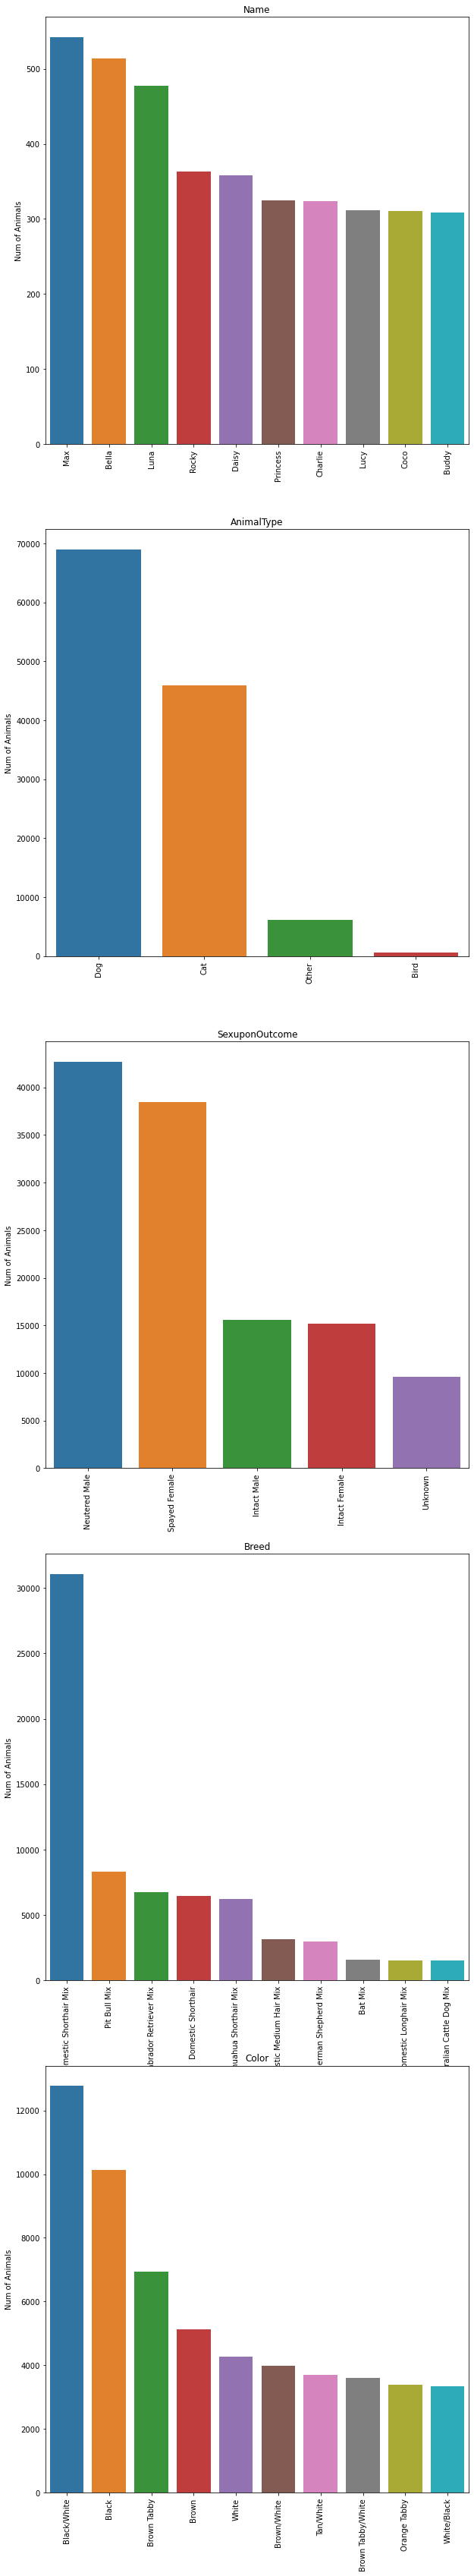

In [12]:
# Obtain headers.
headers = df.dtypes.index

# Not all of these are categorical variables.  
# We need categorical headers and continuous headers, with two different types of plots.

# Categorical headers of features.
cat_headers = ['Name', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color']

# Plot paretos of top 10 values in each column.
fig, ax = plt.subplots(len(cat_headers[0:]), 1, figsize=(10, len(cat_headers)*12))
for i, column in enumerate(cat_headers[0:]):
    to_plot = df[column].value_counts().head(10)
    plot=sns.barplot(x=to_plot.index, y=to_plot, ax=ax[i])
    plot.set_xticklabels(to_plot.index, rotation=90)
    plot.set_title(column)
    plot.set_ylabel("Num of Animals")
fig.show()

A breakdown of `Animal Type` shows that there are mainly dogs and cats in the dataset, with dogs accounting for about 60% of cases. The is a quite big portion of Other animals, and a very little quantity of Bird and Livestock types.

`Sex Upon Outcome` shows us whether the animal is male or female and whether they were spayed or neutered (fixed) prior to the outcome. There is a roughly even split between male and female animals, an overwhelming majority of which were spayed or neutered upon outcome. There are also a small, but notable, quantity of unknowns. We will look further below at this variable's interaction with animal outcomes.

The `Breed` feature is dominated by domestic shorthair cats, which is a catch-all breed label and by far the most common type of cat. There are nearly 25,000 of these. No other breed exceeds 7,000. The most common dog breed is Pitbull Mix.

The most common `Color` is Black/White, followed closely by Black. Taken together as predominantly black, these two colors would substantially outweigh any others. Brown Tabby and Brown Tabby/White are the next most common colors, which is interesting, as these are colors that are only attributable to cats. Black/White and Black could be either dogs or cats. The other top colors are evenly distributed.

In [13]:
df_sex_dropna = df.dropna(subset=['SexuponOutcome'])
df_sex_outcome = df_sex_dropna.groupby(['OutcomeType', 'SexuponOutcome']).agg({'AnimalType':'size'}).rename(columns={'AnimalType':'# of Animals'}).reset_index()
df_sex_outcome

,OutcomeType,SexuponOutcome,# of Animals
0,Adoption,Intact Female,1193
1,Adoption,Intact Male,1028
2,Adoption,Neutered Male,26282
3,Adoption,Spayed Female,25699
4,Adoption,Unknown,154
5,Died,Intact Female,289
6,Died,Intact Male,351
7,Died,Neutered Male,92
8,Died,Spayed Female,81
9,Died,Unknown,334


Examining the distribution of sexes per outcome illuminates the story better than the earlier graphic representation. More than 40,000 of the adopted animals were spayed or neutered upon adoption. Only 1802 were not. Of the animals that were returned to owners, a large majority had also been spayed or neutered. Among the other category, spayed/neutered/male/female were all evenly distributed. Most of the unknowns are seen in the transfer outcome. We will look to binarize gender and whether an animal was fixed for our analysis below.

Next, we look into the Age Upon Outcome feature variable. We believed that it is important to make the ages variable continuous, as opposed to categorical, as the relationship of age is continuous in nature. The most logical unit to standardize ages is weeks. Most of the ages are given in weeks, months, or years, all of which easily transform to weeks. Several ages are given in days, but all are 6 days or fewer. We will standardize these as zero weeks so that they are on the same scale as the rest of the data.

In [14]:
# Map all AgeuponOutcome values to numbers. Mapped to weeks and rounded to the nearest week.
df['AgeuponOutcome'] = df['AgeuponOutcome'].map({'1 week': 1, '1 weeks': 1, '2 weeks': 2, '3 weeks': 3,
                                                             '4 weeks': 4, '5 weeks': 5, '1 month': 4, '2 months': 9,
                                                             '3 months': 13, '4 months': 17, '5 months': 21, 
                                                             '6 months': 26, '7 months': 30, '8 months': 34, 
                                                             '9 months': 38, '10 months': 43, '11 months': 47, 
                                                             '1 year': 52, '2 years': 204, '3 years': 156,
                                                             '4 years': 208, '5 years': 260, '6 years': 312, 
                                                             '7 years': 364, '8 years': 416, '9 years': 468, 
                                                             '10 years': 520, '11 years': 572, '12 years': 624, 
                                                             '13 years': 676, '14 years': 728, '15 years': 780, 
                                                             '16 years': 832, '17 years': 884, '18 years': 936, 
                                                             '20 years': 1040, '0 years': 26, '1 day': 0, '2 days': 0,
                                                             '3 days': 0, '4 days': 0, '5 days': 0, '6 days': 0})

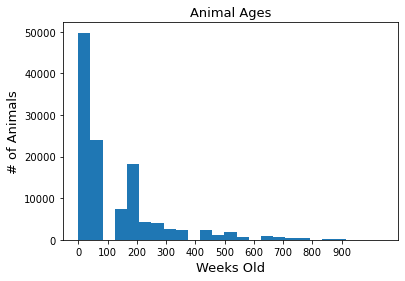

In [15]:
df_age_dropna = df.dropna(subset=['AgeuponOutcome'])

plt.hist(df_age_dropna['AgeuponOutcome'], bins = 25) 

plt.title("Animal Ages")
plt.xlabel("Weeks Old")
plt.ylabel("# of Animals")
plt.xticks(np.arange(0, 1000, step=100))

# Font size transformations.
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(13)

plt.grid(False)

A substantial portion of the animals in the dataset reached their outcomes at under one year of age (52 weeks). We see sizable numbers of outcomes up to the four-year mark (208 weeks). After four years of age, outcomes drop precipitously.

In [16]:
df_age_dropna_2 = df_age_dropna[(df_age_dropna.AgeuponOutcome <= 104)]
df_age_dropna_3 = df_age_dropna[(df_age_dropna.AgeuponOutcome <= 156)]
print("Examining the ages of younger animals further, ", round((df_age_dropna_2.shape[0] / 
                                                                df_age_dropna.shape[0])*100,2), 
      "% of animals are under the age of two years old and ", round((df_age_dropna_3.shape[0] / 
                                                                     df_age_dropna.shape[0])*100,2),
     "% are under the age of three years old.", sep="")

Examining the ages of younger animals further, 60.77% of animals are under the age of two years old and 66.84% are under the age of three years old.


In [17]:
df_age_outcome = df_age_dropna.groupby('OutcomeType').agg({'AnimalType':'size', 
                                                                       'AgeuponOutcome':'mean'}).rename(columns={'AnimalType':'# of Animals',
                                                                                                                 'AgeuponOutcome':'Avg. Age Upon Outcome (in Wk)'}).reset_index()
print("Avg. Age of Animals Upon Outcome:", (round(df_age_dropna.AgeuponOutcome.mean())), "weeks")

df_age_outcome.round(1)

Avg. Age of Animals Upon Outcome: 124 weeks


,OutcomeType,# of Animals,Avg. Age Upon Outcome (in Wk)
0,Adoption,54355,99.1
1,Died,1147,86.8
2,Euthanasia,8290,149.1
3,Return to Owner,21254,223.9
4,Transfer,36309,97.2


From the information above, we can see that a more likely outcome for younger animals is to be `Transfer` or `Adoption`, while older animals are more likely to be `returned to their owner` or `euthanized`. While the `Died` outcome has the lowest average age upon outcome, only 0.7% of animals fall into this category. Therefore, we can assume that many of these animals were unhealthy upon birth and died young.

The age variable is explicitly defined as the age upon outcome; we do not know the ages of animals when they entered shelters. We also do not know how long animals were at the shelter prior to their outcome, and we have no insights into animals still in shelters.

Next, we will look at the `DateTime` column to understand a little more about trends over time in the dataset. We will assume that the `DateTime` column references when the outcome of each animal was determined. We will evaluate this information over time by week to group the data.

In [18]:
# Convert our DateTime column to the proper format and then group by week.
df['DateTime'] = pd.to_datetime(df['DateTime']) - pd.to_timedelta(7, unit='d')
df_time = df.groupby([pd.Grouper(key='DateTime', freq='W-SUN')]).size().reset_index().sort_values('DateTime')
df_time.columns = ['DateTime', 'All']

# Filter for the specific outcome types so that we can later look at the differences by outcome type.
headers = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia', 'Died']
for Outcome in headers:
    df_outcome = df[df.OutcomeType == Outcome].groupby([pd.Grouper(key='DateTime', freq='W-SUN')]).size().reset_index().sort_values('DateTime')
    df_time = pd.merge(df_time, df_outcome, on='DateTime', how='outer')

# Rename the columns to represent each outcome header.
df_time.columns = ['DateTime', 'All', 'Adoption', 'Transfer', 'Return to Owner', 'Euthanasia', 'Died']

df_time

,DateTime,All,Adoption,Transfer,Return to Owner,Euthanasia,Died
0,2013-09-29,306,116,101,57,28,4.0
1,2013-10-06,420,185,139,52,42,2.0
2,2013-10-13,388,130,162,58,36,2.0
3,2013-10-20,332,116,119,53,38,6.0
4,2013-10-27,337,158,91,46,41,1.0
...,...,...,...,...,...,...,...
371,2020-11-08,243,97,41,23,12,2.0
372,2020-11-15,163,83,37,20,15,1.0
373,2020-11-22,154,85,30,20,13,2.0
374,2020-11-29,241,121,82,18,7,NaN


No handles with labels found to put in legend.


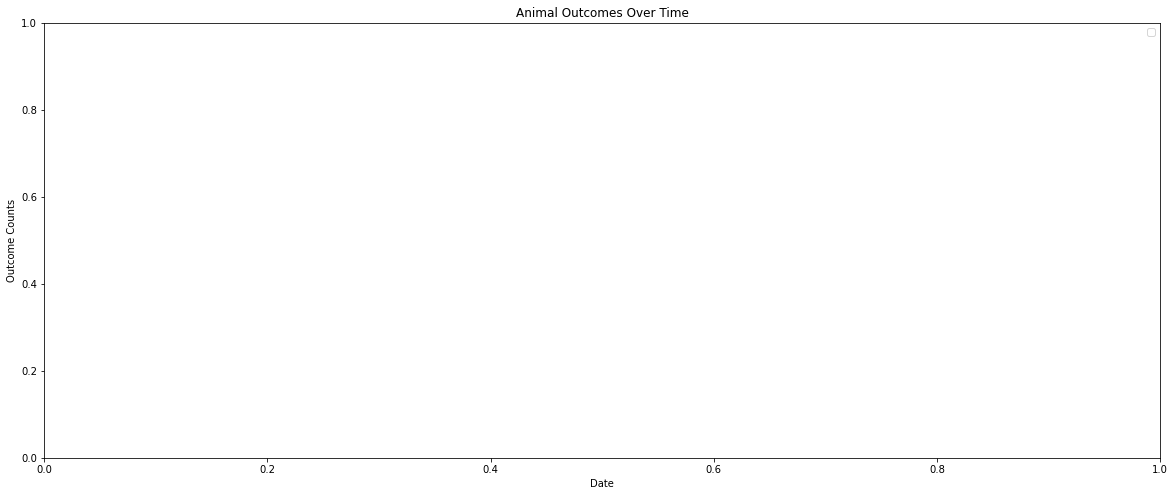

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
# ax = df_time.iloc[1:1, 1:1].plot(ax = ax, x=df_time['DateTime'], sort_columns=True, linewidth=3.0)

plt.xlabel('Date')
plt.ylabel('Outcome Counts')
plt.title('Animal Outcomes Over Time')
ax.legend()
plt.show()

From the `DateTime` analysis, we are able to evaluate animal outcomes from Sep 2013 through Dec 2020. We see that most animals are adopted in the summertime, around July and August. Adoption outcomes spike a bit during this time period as well; however, all other outcomes are evenly distributed throughout the time period of analysis.

# Feature Manipulation and Binarization

## Combining Features

Before binarizing features, we thought doing some simple feature selection could be a good first start. As the breed type has over 2,300 variations and color has over 500 variations, we will see if combining any like features could make sense.

In [20]:
# Evaluate the Breed feature set for combination.
df_breed_list = df['Breed'].tolist()
df_breed_dict = {i:df_breed_list.count(i) for i in set(df_breed_list)}

prior_unique_breeds = df['Breed'].describe()[1]
print("Number of unique breeds within the dataset:", prior_unique_breeds)

# Analyze the different combinations of breeds.
for k in sorted(df_breed_dict): 
    print(k,": ",df_breed_dict[k], sep="", end=", ")

Number of unique breeds within the dataset: 2597


Abyssinian: 7, Abyssinian Mix: 9, Affenpinscher: 1, Affenpinscher Mix: 8, Afghan Hound Mix: 1, Afghan Hound/German Shepherd: 1, Afghan Hound/Labrador Retriever: 1, African Mix: 1, Airedale Terrier: 3, Airedale Terrier Mix: 28, Airedale Terrier/Irish Terrier: 1, Airedale Terrier/Labrador Retriever: 2, Airedale Terrier/Miniature Schnauzer: 1, Airedale Terrier/Otterhound: 2, Airedale Terrier/Standard Poodle: 1, Akbash Mix: 6, Akita: 17, Akita Mix: 52, Akita/Australian Cattle Dog: 6, Akita/Belgian Malinois: 2, Akita/Border Collie: 3, Akita/Chow Chow: 1, Akita/German Shepherd: 6, Akita/Great Pyrenees: 1, Akita/Labrador Retriever: 3, Akita/Mastiff: 1, Akita/Pit Bull: 2, Akita/Siberian Husky: 4, Alaskan Husky: 63, Alaskan Husky Mix: 124, Alaskan Husky/Australian Shepherd: 3, Alaskan Husky/Border Collie: 2, Alaskan Husky/Catahoula: 2, Alaskan Husky/Chow Chow: 1, Alaskan Husky/German Shepherd: 32, Alaskan Husky/Labrador Retriever: 8, Alaskan Husky/Miniature Pinscher: 1, Alaskan Klee Kai: 1, Ala

3, Labrador Retriever/Blue Lacy: 17, Labrador Retriever/Border Collie: 143, Labrador Retriever/Border Terrier: 2, Labrador Retriever/Boston Terrier: 2, Labrador Retriever/Boxer: 78, Labrador Retriever/Brittany: 2, Labrador Retriever/Bullmastiff: 1, Labrador Retriever/Cardigan Welsh Corgi: 3, Labrador Retriever/Catahoula: 41, Labrador Retriever/Chesa Bay Retr: 4, Labrador Retriever/Chihuahua Shorthair: 2, Labrador Retriever/Chinese Sharpei: 44, Labrador Retriever/Chow Chow: 54, Labrador Retriever/Cocker Spaniel: 2, Labrador Retriever/Collie Rough: 4, Labrador Retriever/Collie Smooth: 8, Labrador Retriever/Dachshund: 31, Labrador Retriever/Dachshund Wirehair: 4, Labrador Retriever/Dalmatian: 6, Labrador Retriever/Doberman Pinsch: 22, Labrador Retriever/English Bulldog: 1, Labrador Retriever/English Foxhound: 1, Labrador Retriever/English Pointer: 2, Labrador Retriever/English Springer Spaniel: 2, Labrador Retriever/Finnish Spitz: 1, Labrador Retriever/Flat Coat Retriever: 8, Labrador Ret

: 2, Staffordshire: 56, Staffordshire Mix: 654, Staffordshire/American Bulldog: 1, Staffordshire/Australian Cattle Dog: 3, Staffordshire/Basenji: 1, Staffordshire/Basset Hound: 1, Staffordshire/Beagle: 3, Staffordshire/Blue Lacy: 2, Staffordshire/Border Collie: 1, Staffordshire/Boston Terrier: 2, Staffordshire/Boxer: 10, Staffordshire/Bull Terrier: 3, Staffordshire/Bulldog: 1, Staffordshire/Chinese Sharpei: 2, Staffordshire/Dachshund: 1, Staffordshire/English Bulldog: 8, Staffordshire/French Bulldog: 1, Staffordshire/Labrador Retriever: 10, Staffordshire/Pit Bull: 2, Staffordshire/Plott Hound: 3, Staffordshire/Rat Terrier: 1, Standard Poodle: 12, Standard Poodle Mix: 28, Standard Poodle/Australian Shepherd: 1, Standard Poodle/Golden Retriever: 3, Standard Poodle/Jack Russell Terrier: 1, Standard Poodle/Labrador Retriever: 19, Standard Poodle/Whippet: 1, Standard Schnauzer: 13, Standard Schnauzer Mix: 57, Standard Schnauzer/Border Terrier: 1, Standard Schnauzer/German Shepherd: 3, Stand

In [21]:
# Remove the secondary breed name.
def split_breed(x):
    if '/' in x['Breed'] : return x['Breed'].split('/', 1)[1]
    else : return x['Breed']
    
df['Breed'] = df.apply(split_breed, axis=1)

In [22]:
# Remove the word "mix" from the breed type.
df['Breed'] = df['Breed'].str.replace(' Mix', '')

In [23]:
print("We have taken the unique number of breeds from",prior_unique_breeds, "to", 
      df['Breed'].describe()[1], "by removing the secondary breed type",
      "and the word \"mix\".")

We have taken the unique number of breeds from 2597 to 372 by removing the secondary breed type and the word "mix".


In [24]:
# Evaluate the Color feature set for combination.
df_color_list = df['Color'].tolist()
df_color_dict = {i:df_color_list.count(i) for i in set(df_color_list)}

prior_unique_colors = df['Color'].describe()[1]
print("Number of unique colors within the dataset:", prior_unique_colors)

# Analyzing the different combinations of colors.
for k in sorted(df_color_dict):
    print(k,": ",df_color_dict[k], sep="", end=", ")

Number of unique colors within the dataset: 591
Agouti: 20, Agouti/Brown Tabby: 1, Agouti/Cream: 1, Agouti/Gray: 1, Agouti/White: 2, Apricot: 77, Apricot/Brown: 3, Apricot/Tricolor: 2, Apricot/White: 12, Black: 10135, Black Brindle: 114, Black Brindle/Black: 10, Black Brindle/Blue: 1, Black Brindle/Blue Tick: 1, Black Brindle/Brown: 17, Black Brindle/Brown Brindle: 3, Black Brindle/Tan: 3, Black Brindle/White: 250, Black Smoke: 174, Black Smoke/Black: 1, Black Smoke/Black Tiger: 1, Black Smoke/Blue Tick: 1, Black Smoke/Brown: 1, Black Smoke/Brown Tabby: 1, Black Smoke/Chocolate: 1, Black Smoke/Gray: 1, Black Smoke/White: 50, Black Tabby: 234, Black Tabby/Black: 1, Black Tabby/Gray: 1, Black Tabby/Gray Tabby: 1, Black Tabby/Orange: 1, Black Tabby/White: 74, Black Tiger: 4, Black Tiger/White: 2, Black/Black: 156, Black/Black Brindle: 15, Black/Black Smoke: 6, Black/Black Tabby: 2, Black/Blue: 7, Black/Blue Merle: 19, Black/Blue Tick: 35, Black/Brown: 2572, Black/Brown Brindle: 149, Black

In [25]:
# Remove the secondary color name to focus on the principal color.
def split_color(x):
    if '/' in x['Color'] : return x['Color'].split('/', 1)[1]
    else : return x['Color']
    
df['Color'] = df.apply(split_color, axis=1)

In [26]:
print("We have taken the unique number of colors from", prior_unique_colors, "to", 
      df['Color'].describe()[1], "by focusing on the primary color",
      "\nand removing the secondary color.")

We have taken the unique number of colors from 591 to 60 by focusing on the primary color 
and removing the secondary color.


Moving forward, we are focusing on primary breed and color, working under the assumption that someone adopting an animal is likely to focus on the predominant feature in each of these categories. When a potential adopter sees border collie mix or border collie/labrador retriever, they are likely to process this as "border collie" first and foremost. Colors work the same way: the difference between calico vs. calico/white is negligible. 

The remaining colors could be reduced further, as they mix colors and coat types (blue vs. blue tabby), but we determined that these were unique enough to keep separate in a single field.

## Train Data Transformations and Binarization

In order to transform our dataset and make it ready for model evaluation, we are going to create dummy variables for all of our continuous variables and binarize all of our features. For our age variable, we are going to normalize all of the data, as the variable is continuous.

In [27]:
df_binarize = df.copy()
df_binarize.head(1)

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A821019,Spot,2020-12-01 12:37:00,Adoption,Adopted,Dog,Neutered Male,156.0,Pit Bull,Black


In [28]:
# Split SexuponOutcome into dummy variables, so that both will only have two options.
df_binarize['State'], df_binarize['Gender'] = df_binarize['SexuponOutcome'].str.split(' ', 1).str

df_binarize['State'] = df_binarize['State'].map({'Neutered': 'Fixed', 
                                                             'Spayed': 'Fixed', 
                                                             'Intact': 'Intact'})
df_binarize.head(1)

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,State,Gender
0,A821019,Spot,2020-12-01 12:37:00,Adoption,Adopted,Dog,Neutered Male,156.0,Pit Bull,Black,Fixed,Male


In [29]:
# Pick the column(s) to binarize.
df_binarize_state = pd.get_dummies(df_binarize['State'])
df_binarize_gender = pd.get_dummies(df_binarize['Gender'])

# Only keep one, as we only have two variables.
df_binarize_state = df_binarize_state['Fixed']
df_binarize_gender = df_binarize_gender['Male']

# Combine the state binarization and the original dataset.
df_binarize = pd.concat([df_binarize, df_binarize_state, df_binarize_gender], axis=1)

# Change the name of the columns that we just concatenated.
df_binarize = df_binarize.rename(index=str, columns={'Fixed': 'State(Fixed=1)', 'Male': 'Gender(Male=1)'})
                                                                 
df_binarize.head(1)

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,State,Gender,State(Fixed=1),Gender(Male=1)
0,A821019,Spot,2020-12-01 12:37:00,Adoption,Adopted,Dog,Neutered Male,156.0,Pit Bull,Black,Fixed,Male,1,1


In [30]:
# Pick the column(s) to binarize.
df_binarize_animaltype = pd.get_dummies(df_binarize['AnimalType'])
df_binarize_breed = pd.get_dummies(df_binarize['Breed'])
df_binarize_color = pd.get_dummies(df_binarize['Color'])

# Need to keep all of the columns, as we have more than two breeds.
# Combine the breed binarization and the original dataset.
df_binarize = pd.concat([df_binarize, df_binarize_animaltype, df_binarize_breed, df_binarize_color], axis=1)

df_binarize.head(1)

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Silver Tabby,Tan,Torbie,Tortie,Tortie Point,Tricolor,Unknown,White,Yellow,Yellow Brindle
0,A821019,Spot,2020-12-01 12:37:00,Adoption,Adopted,Dog,Neutered Male,156.0,Pit Bull,Black,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Normalize age upon outcome.
df_binarize['AgeuponOutcome_norm'] = df_binarize['AgeuponOutcome']/max(df_binarize['AgeuponOutcome'])

df_binarize[df_binarize['AgeuponOutcome'].isnull()].count()

ID                     131
Name                   123
DateTime               131
OutcomeType             40
OutcomeSubtype         131
                      ... 
Unknown                131
White                  131
Yellow                 131
Yellow Brindle         131
AgeuponOutcome_norm      0
Length: 451, dtype: int64

In [35]:
# Fill NaN values with the median value for the column.
df_binarize['AgeuponOutcome_norm'].fillna(df_binarize['AgeuponOutcome_norm'].median(), inplace=True)

#print(df_binarize[df_binarize['ID'] == 'A825923'])
#df_binarize[df_binarize['ID'] == 'A825923']['Name'] = 'patata'
#df_binarize[df_binarize['ID'] == 'A825923']['Name']
df_binarize[df_binarize['AgeuponOutcome_norm'].isnull()]

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Tan,Torbie,Tortie,Tortie Point,Tricolor,Unknown,White,Yellow,Yellow Brindle,AgeuponOutcome_norm
20,A825923,Harvey,2020-12-01 00:00:00,NaN,Other,Cat,Intact Male,NaN,Domestic Shorthair,Unknown,...,0,0,0,0,0,1,0,0,0,NaN
64,A826774,NaN,2020-11-30 00:00:00,NaN,Other,Cat,NaN,NaN,Sphynx,Unknown,...,0,0,0,0,0,1,0,0,0,NaN
102,A825613,Bigluis,2020-11-28 00:00:00,NaN,Other,Cat,Intact Male,NaN,American Shorthair,Unknown,...,0,0,0,0,0,1,0,0,0,NaN
116,A826701,Chubby,2020-11-27 14:47:00,NaN,Other,Dog,Intact Male,NaN,Chihuahua Shorthair,Unknown,...,0,0,0,0,0,1,0,0,0,NaN
201,A826598,NaN,2020-11-26 10:19:00,NaN,Other,Dog,Intact Female,NaN,Doberman Pinsch,Unknown,...,0,0,0,0,0,1,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108711,A682010,Babyblueeyes,2014-06-18 13:26:00,Return to Owner,Other,Cat,Neutered Male,NaN,Domestic Shorthair,Seal Point,...,0,0,0,0,0,0,0,0,0,NaN
112476,A464377,Tiger,2014-04-08 18:06:00,Return to Owner,Other,Dog,Neutered Male,NaN,Chihuahua Shorthair,Brown,...,0,0,0,0,0,0,0,0,0,NaN
113619,A674725,Monte,2014-03-14 19:21:00,Return to Owner,Other,Dog,Intact Male,NaN,Cocker Spaniel,White,...,0,0,0,0,0,0,1,0,0,NaN
115972,A559240,Chikita,2014-01-18 12:02:00,Euthanasia,Suffering,Dog,Spayed Female,NaN,Miniature Poodle,White,...,0,0,0,0,0,0,1,0,0,NaN


As discussed above, we decided not to binarize the `Name` variable, as the dataset has over 6,000 unique names. With just over 26,700 rows in the dataset, and names only present in just over 19,000, we believed that the dataset would be too sparse if we created a unique column for each name. The sparsity would lead to the names likely not being very good features in predicting animal outcomes.

In [184]:
# Print full list of columns from binarization to check work.
print("Num of columns:", len(list(df_binarize.columns.values)), 
      "\nand columns:", list(df_binarize.columns.values),end="")

Num of columns: 451 
and columns: ['ID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'State', 'Gender', 'State(Fixed=1)', 'Gender(Male=1)', 'Bird', 'Cat', 'Dog', 'Other', 'Abyssinian', 'Affenpinscher', 'Afghan Hound', 'African', 'Airedale Terrier', 'Akbash', 'Akita', 'Alaskan Husky', 'Alaskan Klee Kai', 'Alaskan Malamute', 'American', 'American Bulldog', 'American Curl Shorthair', 'American Eskimo', 'American Foxhound', 'American Pit Bull Terrier', 'American Sable', 'American Shorthair', 'American Staffordshire Terrier', 'American Wirehair', 'Anatol Shepherd', 'Angora', 'Angora-English', 'Angora-French', 'Angora-Satin', 'Armadillo', 'Australian Cattle Dog', 'Australian Kelpie', 'Australian Shepherd', 'Australian Terrier', 'Balinese', 'Bantam', 'Barred Rock', 'Basenji', 'Basset Hound', 'Bat', 'Beagle', 'Bearded Collie', 'Beauceron', 'Bedlington Terr', 'Belgian Hare', 'Belgian Malinois', 'Belgian Sheepdog', 'Bel

In [185]:
# Check sparsity of the training set.
print("Sparsity of the binarized training set:", '%.2f'%(100*((np.product(df_binarize.shape) - np.count_nonzero(df_binarize))/np.product(df_binarize.shape))),"%")

Sparsity of the binarized training set: 96.20 %


Despite the feature consolidation, the binarization resulted in a very sparse data set.

In [186]:
# Export a CSV record of the dataset.
if not os.path.exists('./data'):
        os.makedirs('./data')
        
df_binarize.to_csv('./data/df_binarization.csv')